In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# pip install split-folders tqdm

In [5]:
import os, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import splitfolders

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, image_dataset_from_directory

Load and preprocess images

In [ ]:
# Split folders into train-validation-test. Only need to run once.
splitfolders.ratio("/content/drive/MyDrive/Colab Notebooks/test_images", 
                   output="/content/drive/MyDrive/Colab Notebooks/split_images", 
                   seed=1, ratio=(.6, .2, .2), group_prefix=None)

Copying files: 5539 files [02:55, 31.54 files/s]


In [ ]:
# image_dir = Path('/content/drive/MyDrive/Colab Notebooks/test_images')
# 
# # Get filepaths and labels
# filepaths = list(image_dir.glob(r'**/*.png'))
# labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
# filepaths = pd.Series(filepaths, name='Filepath').astype(str)
# labels = pd.Series(labels, name='Label')
# 
# # Concatenate filepaths and labels
# image_df = pd.concat([filepaths, labels], axis=1)
# print(image_df.head(3))
# print(image_df.shape)

In [6]:
batch_size = 32
img_height = 128
img_width = 128

In [7]:
# Rather than load the entire 5000+ image dataset, we'll use tf.data.Dataset to generate training and validation sets
train_dir = '/content/drive/MyDrive/Colab Notebooks/split_images/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/split_images/val'

train_ds = image_dataset_from_directory(
  train_dir,
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = image_dataset_from_directory(
  val_dir,
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3318 files belonging to 12 classes.
Found 1102 files belonging to 12 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


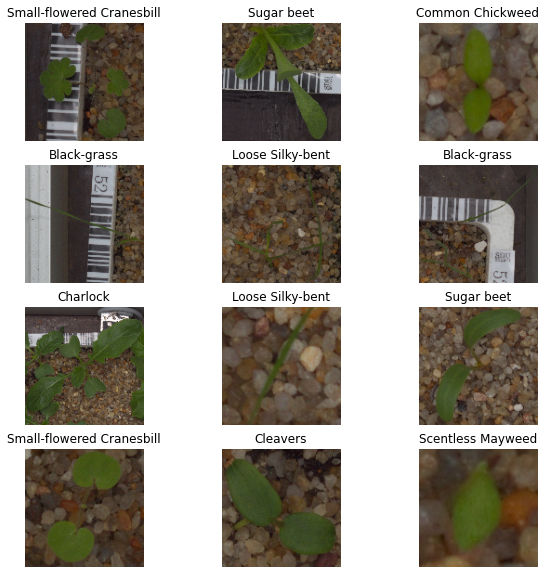

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
# Rescales the RGB values from 0-255 to 0-1
normalize_layer = Rescaling(1./255)
normalized_train = train_ds.map(lambda x, y: (normalize_layer(x), y))
normalized_val = val_ds.map(lambda x, y: (normalize_layer(x), y))

Build baseline model

In [10]:
def init_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, kernel_size=(5,5), input_shape=(128, 128, 3), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(3,3)))
  model.add(layers.Conv2D(64, kernel_size=(5,5), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(3,3)))
  model.add(layers.Flatten())
  model.add(layers.Dense(16))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(12, activation='softmax'))
  optimizer = Adam(learning_rate=0.001)
  model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
 
  return model

In [14]:
model = init_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 41, 41, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 16)               

In [15]:
mc = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/model.{epoch:02d}-{val_loss:.2f}.h5', 
                     monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(normalized_train,
          validation_data=normalized_val,
          epochs=20,
          batch_size=128, 
          verbose=1,
          callbacks=mc)

Epoch 1/20
104/104 [==============================] - 502s 5s/step - loss: 2.4147 - accuracy: 0.1504 - val_loss: 2.1970 - val_accuracy: 0.2514
Epoch 2/20
104/104 [==============================] - 28s 257ms/step - loss: 2.0035 - accuracy: 0.3234 - val_loss: 1.6980 - val_accuracy: 0.4138
Epoch 3/20
104/104 [==============================] - 28s 254ms/step - loss: 1.7516 - accuracy: 0.3933 - val_loss: 1.6471 - val_accuracy: 0.4319
Epoch 4/20
104/104 [==============================] - 28s 254ms/step - loss: 1.6325 - accuracy: 0.4382 - val_loss: 1.4194 - val_accuracy: 0.5027
Epoch 5/20
104/104 [==============================] - 28s 254ms/step - loss: 1.4644 - accuracy: 0.5060 - val_loss: 1.2740 - val_accuracy: 0.5871
Epoch 6/20
104/104 [==============================] - 31s 289ms/step - loss: 1.3548 - accuracy: 0.5350 - val_loss: 1.2062 - val_accuracy: 0.6098
Epoch 7/20
104/104 [==============================] - 28s 257ms/step - loss: 1.2724 - accuracy: 0.5702 - val_loss: 1.1309 - val_accu

In [16]:
# Load the best model from Model Checkpoint callback (to reduce overfitting)
best_model = load_model('/content/drive/MyDrive/Colab Notebooks/model.18-0.87.h5')

Predict and evaluate model

In [18]:
test_dir = '/content/drive/MyDrive/Colab Notebooks/split_images/test'
test_ds = image_dataset_from_directory(
  test_dir,
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1119 files belonging to 12 classes.


In [21]:
best_model.evaluate(test_ds)

35/35 [==============================] - 6s 143ms/step - loss: 233.1814 - accuracy: 0.5103


[233.18141174316406, 0.5102770328521729]

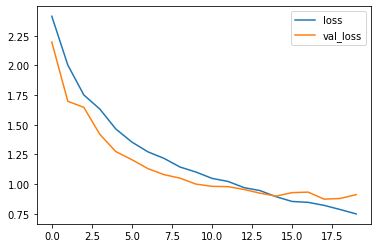

In [22]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

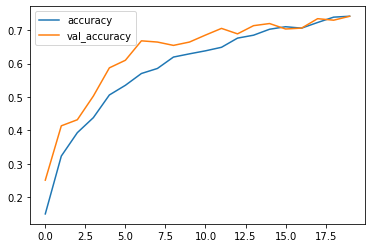

In [23]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

Save and load model

In [ ]:
# From Elizabeth's Colab Notebook
model.save('/content/drive/MyDrive/Colab Notebooks/seedling_model1.h5')


In [ ]:
model_test = load_model('/content/drive/MyDrive/Colab Notebooks/seedling_model1.h5')
model_test.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 84, 84, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 80, 80, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 43264)             0         
                                                                 
 dense_2 (Dense)             (None, 16)               